# Simulating a news personalization scenario using Contextual Bandits
> A tutorial to understand the process of building a contextual recommender system using vowpalwabbit

- toc: true
- badges: true
- comments: true
- categories: [reinforcement, contextual]
- image: 

In the Contextual Bandit(CB) introduction tutorial, we learnt about CB and different CB algorithms. In this tutorial we will simulate the scenario of personalizing news content on a site, using CB, to users. The goal is to maximize user engagement quantified by measuring click through rate (CTR).

Let's recall that in a CB setting, a data point has four components,

- Context
- Action
- Probability of choosing action
- Reward/cost for chosen action

In our simulator, we will need to generate a context, get an action/decision for the given context and also simulate generating a reward.

In our simulator, our goal is to maximize reward (click through rate/CTR) or minimize loss (-CTR)

- We have two website visitors: 'Tom' and 'Anna'
- Each of them may visit the website either in the morning or in the afternoon

The **context** is therefore (user, time_of_day)

We have the option of recommending a variety of articles to Tom and Anna. Therefore, **actions** are the different choices of articles: "politics", "sports", "music", "food", "finance", "health", "cheese"

The **reward** is whether they click on the article or not: 'click' or 'no click'

Let's first start with importing the necessary packages:

In [1]:
#hide
!pip install vowpalwabbit

     |████████████████████████████████| 2.6MB 5.5MB/s 


In [2]:
#hide
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

## Simulate reward

In the real world, we will have to learn Tom and Anna's preferences for articles as we observe their interactions. Since this is a simulation, we will have to define Tom and Anna's preference profile. The reward that we provide to the learner will follow this preference profile. Our hope is to see if the learner can take better and better decisions as we see more samples which in turn means we are maximizing the reward.

We will also modify the reward function in a few different ways and see if the CB learner picks up the changes. We will compare the CTR with and without learning.

VW optimizes to minimize **cost which is negative of reward**. Therefore, we will always pass negative of reward as cost to VW.

In [3]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

The reward function below specifies that Tom likes politics in the morning and music in the afternoon whereas Anna likes sports in the morning and politics in the afternoon. It looks dense but we are just simulating our hypothetical world in the format of the feedback the learner understands: cost. If the learner recommends an article that aligns with the reward function, we give a positive reward. In our simulated world this is a click.

In [4]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE


## Understanding VW format

There are some things we need to do to get our input into a format VW understands. This function handles converting from our context as a dictionary, list of articles and the cost if there is one into the text format VW understands.


In [5]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

To understand what's going on here let's go through an example. Here, it's the morning and the user is Tom. There are four possible articles. So in the VW format there is one line that starts with shared, this is the shared context, followed by four lines each corresponding to an article.

In [6]:
#collapse-input
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


## Getting a decision

When we call VW we get a _pmf_, [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function), as the output. Since we are incorporating exploration into our strategy, VW will give us a list of probabilities over the set of actions. This means that the probability at a given index in the list corresponds to the likelihood of picking that specific action. In order to arrive at a decision/action, we will have to sample from this list.

So, given a list `[0.7, 0.1, 0.1, 0.1]`, we would choose the first item with a 70% chance. `sample_custom_pmf` takes such a list and gives us the index it chose and what the probability of choosing that index was.

In [7]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

We have all of the information we need to choose an action for a specific user and context. To use VW to achieve this, we will do the following:

1. We convert our context and actions into the text format we need
2. We pass this example to vw and get the pmf out
3. Now, we sample this pmf to get what article we will end up showing
4. Finally we return the article chosen, and the probability of choosing it (we are going to need the probability when we learn form this example)

In [8]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob



## Simulation set up

Now that we have done all of the setup work and know how to interface with VW, let's simulate the world of Tom and Anna. The scenario is they go to a website and are shown an article. Remember that the reward function allows us to define the worlds reaction to what VW recommends.


We will choose between Tom and Anna uniformly at random and also choose their time of visit uniformly at random. You can think of this as us tossing a coin to choose between Tom and Anna (Anna if heads and Tom if tails) and another coin toss for choosing time of day.


In [9]:
#hide-input
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

We will instantiate a CB learner in VW and then simulate Tom and Anna's website visits `num_iterations` number of times. In each visit, we:

1. Decide between Tom and Anna
2. Decide time of day
3. Pass context i.e. (user, time of day) to learner to get action i.e. article recommendation and probability of choosing action
4. Receive reward i.e. see if user clicked or not. Remember that cost is just negative reward.
5. Format context, action, probability, reward in VW format
6. Learn from the example
    - VW _reduces_ a CB problem to a cost sensitive multiclass classification problem.

This is the same for every one of our simulations, so we define the process in the `run_simulation` function. The cost function must be supplied as this is essentially us simulating how the world works.


In [10]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr


We want to be able to visualize what is occurring, so we are going to plot the click through rate over each iteration of the simulation. If VW is showing actions the get rewards the ctr will be higher. Below is a little utility function to make showing the plot easier.


In [11]:
#hide
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## Scenario 1

We will use the first reward function `get_cost` and assume that Tom and Anna do not change their preferences over time and see what happens to user engagement as we learn. We will also see what happens when there is no learning. We will use the "no learning" case as our baseline to compare to.

### With learning


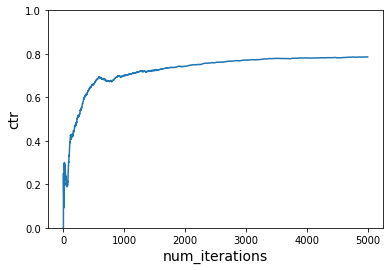

In [12]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

Aside: interactions

You'll notice in the arguments we supply to VW, **we include `-q UA`**. This is telling VW to create additional features which are the features in the (U)ser namespace and (A)ction namespaces multiplied together. This allows us to learn the interaction between when certain actions are good in certain times of days and for particular users. If we didn't do that, the learning wouldn't really work. We can see that in action below.

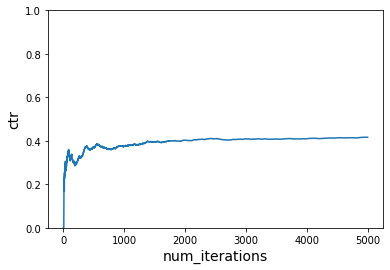

In [13]:
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)


### Without learning
Let's do the same thing again (but with `-q`, but this time show the effect if we don't learn from what happens. The ctr never improves are we just hover around 0.2.

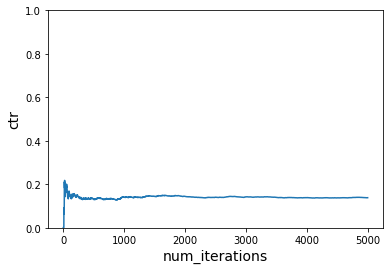

In [14]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

## Scenario 2

In the real world people's preferences change over time. So now in the simulation we are going to incorporate two different cost functions, and swap over to the second one halfway through. Below is a a table of the new reward function we are going to use, `get_cost_1`:

### Tom

| | `get_cost` | `get_cost_new1` |
|:---|:---:|:---:|
| **Morning** | Politics | Politics |
| **Afternoon** | Music | Sports |

### Anna

| | `get_cost` | `get_cost_new1`  |
|:---|:---:|:---:|
| **Morning** | Sports | Sports |
| **Afternoon** | Politics | Sports |

This reward function is still working with actions that the learner has seen previously.


In [15]:
#hide
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new1)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

To make it easy to show the effect of the cost function changing we are going to modify the `run_simulation` function. It is a little less readable now, but it supports accepting a list of cost functions and it will operate over each cost function in turn. This is perfect for what we need.

In [16]:
#hide
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations


In [17]:
#hide
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

### With learning
Let us now switch to the second reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of the web users but it is still working with the same action space as before. We should see the learner pick up these changes and optimize towards the new preferences.


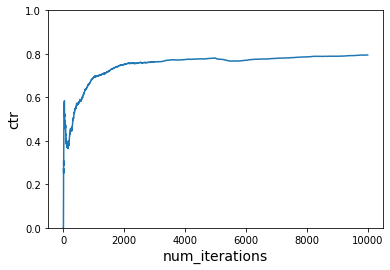

In [18]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

**Note:** The initial spike in CTR depends on the rewards received for the first few examples. When you run on your own, you may see something different initially because our simulator is designed to have randomness.

### Without learning

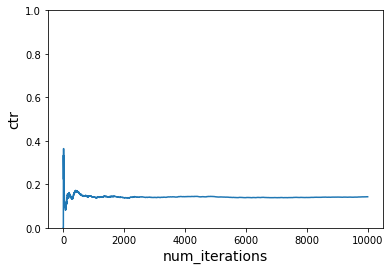

In [19]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

## Scenario 3
In this scenario we are going to start rewarding actions that have never seen a reward previously when we change the cost function.

### Tom

| | `get_cost` | `get_cost_new2` |
|:---|:---:|:---:|
| **Morning** | Politics |  Politics|
| **Afternoon** | Music |   Food |

### Anna

| | `get_cost` | `get_cost_new2` |
|:---|:---:|:---:|
| **Morning** | Sports | Food|
| **Afternoon** | Politics |  Food |


In [20]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE


### With learning
Let us now switch to the third reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of the users and is working with a **different** action space than before. We should see the learner pick up these changes and optimize towards the new preferences


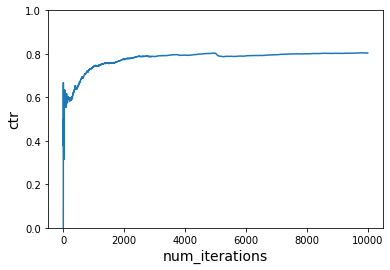

In [21]:
# use first reward function initially and then switch to third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

### Without Learning

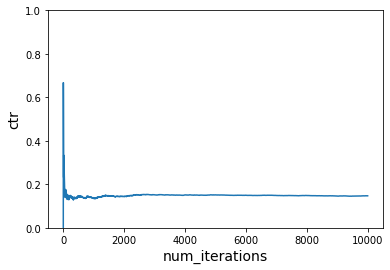

In [22]:
# Do not learn
# use first reward function initially and then switch to third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)

plot_ctr(total_iterations, ctr)

## Summary

This tutorial aimed at showcasing a real world scenario where contextual bandit algorithms can be used. We were able to take a context and set of actions and learn what actions worked best for a given context. We saw that the learner was able to respond rapidly to changes in the world.  We showed that allowing the learner to interact with the world resulted in higher rewards than the no learning baseline.

This tutorial worked with simplistic features. VW supports high dimensional sparse features, different exploration algorithms and policy evaluation approaches.

[credits](https://vowpalwabbit.org/tutorials/cb_simulation.html)